<b> Title: </b> Group 11 Final Project Report - DSCI 100 002 

<b> Group members: </b> Katie Archer, Noor Naila Imtinan Himam, Matthew Yeung, Wenwen Zhao

<b>1. Introduction</b>
<br>
According to scientific research, pulsars are an uncommon form of neutron stars that emit regular pulses of radiation, varying from several seconds to milliseconds in frequency. The potent magnetic fields of these stars generate intense beams of light at both poles. These beams are periodically observed as the pulsar rotates quickly, and they can only be observed with large telescopes when they cross our line of sight from Earth (National Aeronautics and Space Administration, n.d.)

Although pulsars emit a pattern of radio emission that can be detected as they rotate, it can be challenging to distinguish between genuine signals and background noise. Pulsar candidates are being classified as binary classification issues using machine learning tools. The HTRU 2 dataset, which is used to train classification models, includes examples of both real and fake pulsar signals. The class labels used are 0 (negative) and 1 (positive), with the legitimate pulsar examples being the minority positive class. The eight continuous variables are obtained from the integrated pulse profile and the DM-SNR (Disperion Measure - Signal-to-Noise Ratio) curve, which describe the longitude-resolved version of the signal averaged in both time and frequency (Keith et al., 2010). Each candidate in the dataset is described by eight continuous variables, one class variable, and no astronomical information. The integrated pulse profile and the DM-SNR curve are used to determine the eight variables.

In this project, we aim to figure out if information from the integrated pulse profile and DM-SNR curve of pulsar candidates can be used to classify whether signals are legitimate or spurious (real or fake pulsar) with high accuracy, and if so, which predictors will lead to the greatest accuracy.

<b>2. Preliminary exploratory data analysis:</b>


First, we load all of the libraries that we will need for the remainder of this project. This includes installing a package that will allow us to upsample our dataset later on.

In [1]:
#CAUTION: Takes a long time to load.
install.packages("themis")
install.packages("tidymodels")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(GGally)
install.packages("corrplot")
library(corrplot)
library(RColorBrewer)   
library(class)          
library(e1071)          
library(stringr)
library(themis)
devtools::install_github("tidymodels/tune")
set.seed(1)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0          ✔ rsample      1.1.1     
✔ dials        1.2.0          ✔ tune         1.1.1.9000
✔ infer        1.0.2          ✔ workflows    1.1.3     
✔ modeldata    1.0.0          ✔ workflowsets 1.0.0     
✔ parsnip      1.1.0          ✔ yardstick    1.1.0     
✔ recipes      1.0.5          

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::la

<b>Summarize the data in at least one table </b>

We begin by reading in our dataset and tidying it by adding column names and removing any rows with missing values.

In [32]:
pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", 
                                                         "skew_integrated_profile", "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", 
                                                         "skew_dmsnr", "class"))
pulsar_data <- pulsar_data |> 
    drop_na() |>
    mutate(class = as_factor(class))
head(pulsar_data)


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<b> Dataset Exploration Graph 1 (correlation): </b>

In [33]:
options(repr.plot.width = 12, repr.plot.height = 12)
cor_pulse <- cor(pulsar_data)
corrplot(cor_pulse, type="upper", order="hclust",col=brewer.pal(n=8, name="RdYlBu"))

ERROR: Error in cor(pulsar_data): 'x' must be numeric


We can see that there is a different correlation value between the variables where some of them are high value.*** 

<b> Dataset Exploration Graph 2 (variable distribution): </b>

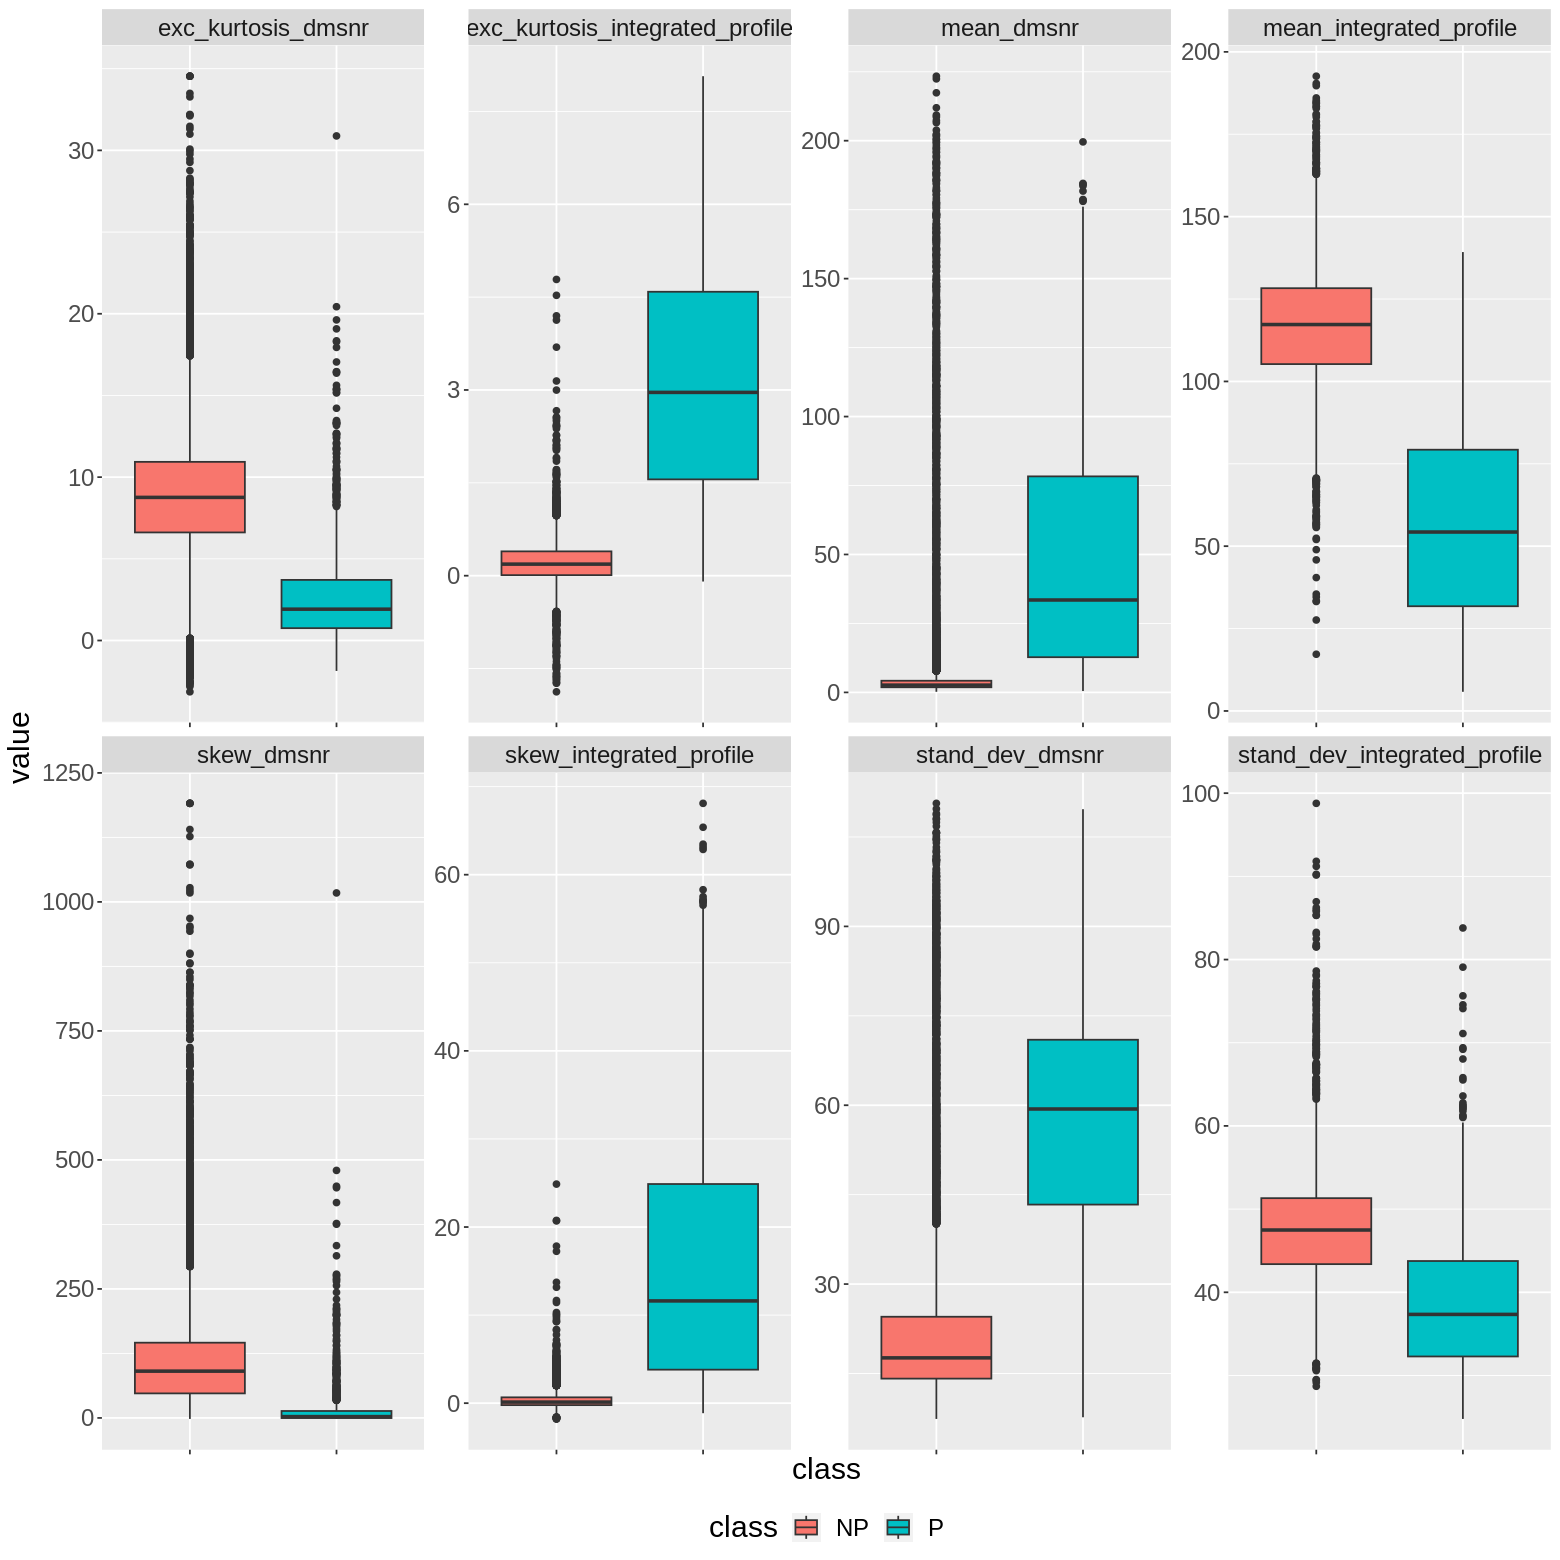

In [34]:
pulsar_data$class <- ifelse(pulsar_data$class == 1, "P", "NP")

options(repr.plot.height = 13, repr.plot.width = 13)

pulsar_data |> gather(predictors, value, -class) %>%
  ggplot(aes(class, value, fill = class)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free", ncol = 4) +
  theme(axis.text.x = element_blank(), legend.position="bottom") +
  theme(text = element_text(size = 18))

As shown above, the distribution graph above shows that some of the variables' values show an evident difference between real and fake pulsars.

Now, we will see the proportion of pulsar and non pulsar dataset to determine a data balancing method.

In [14]:
prop.table(table(pulsar_data$class))


        NP          P 
0.90842552 0.09157448 

In [15]:
table(pulsar_data$class)


   NP     P 
16259  1639 

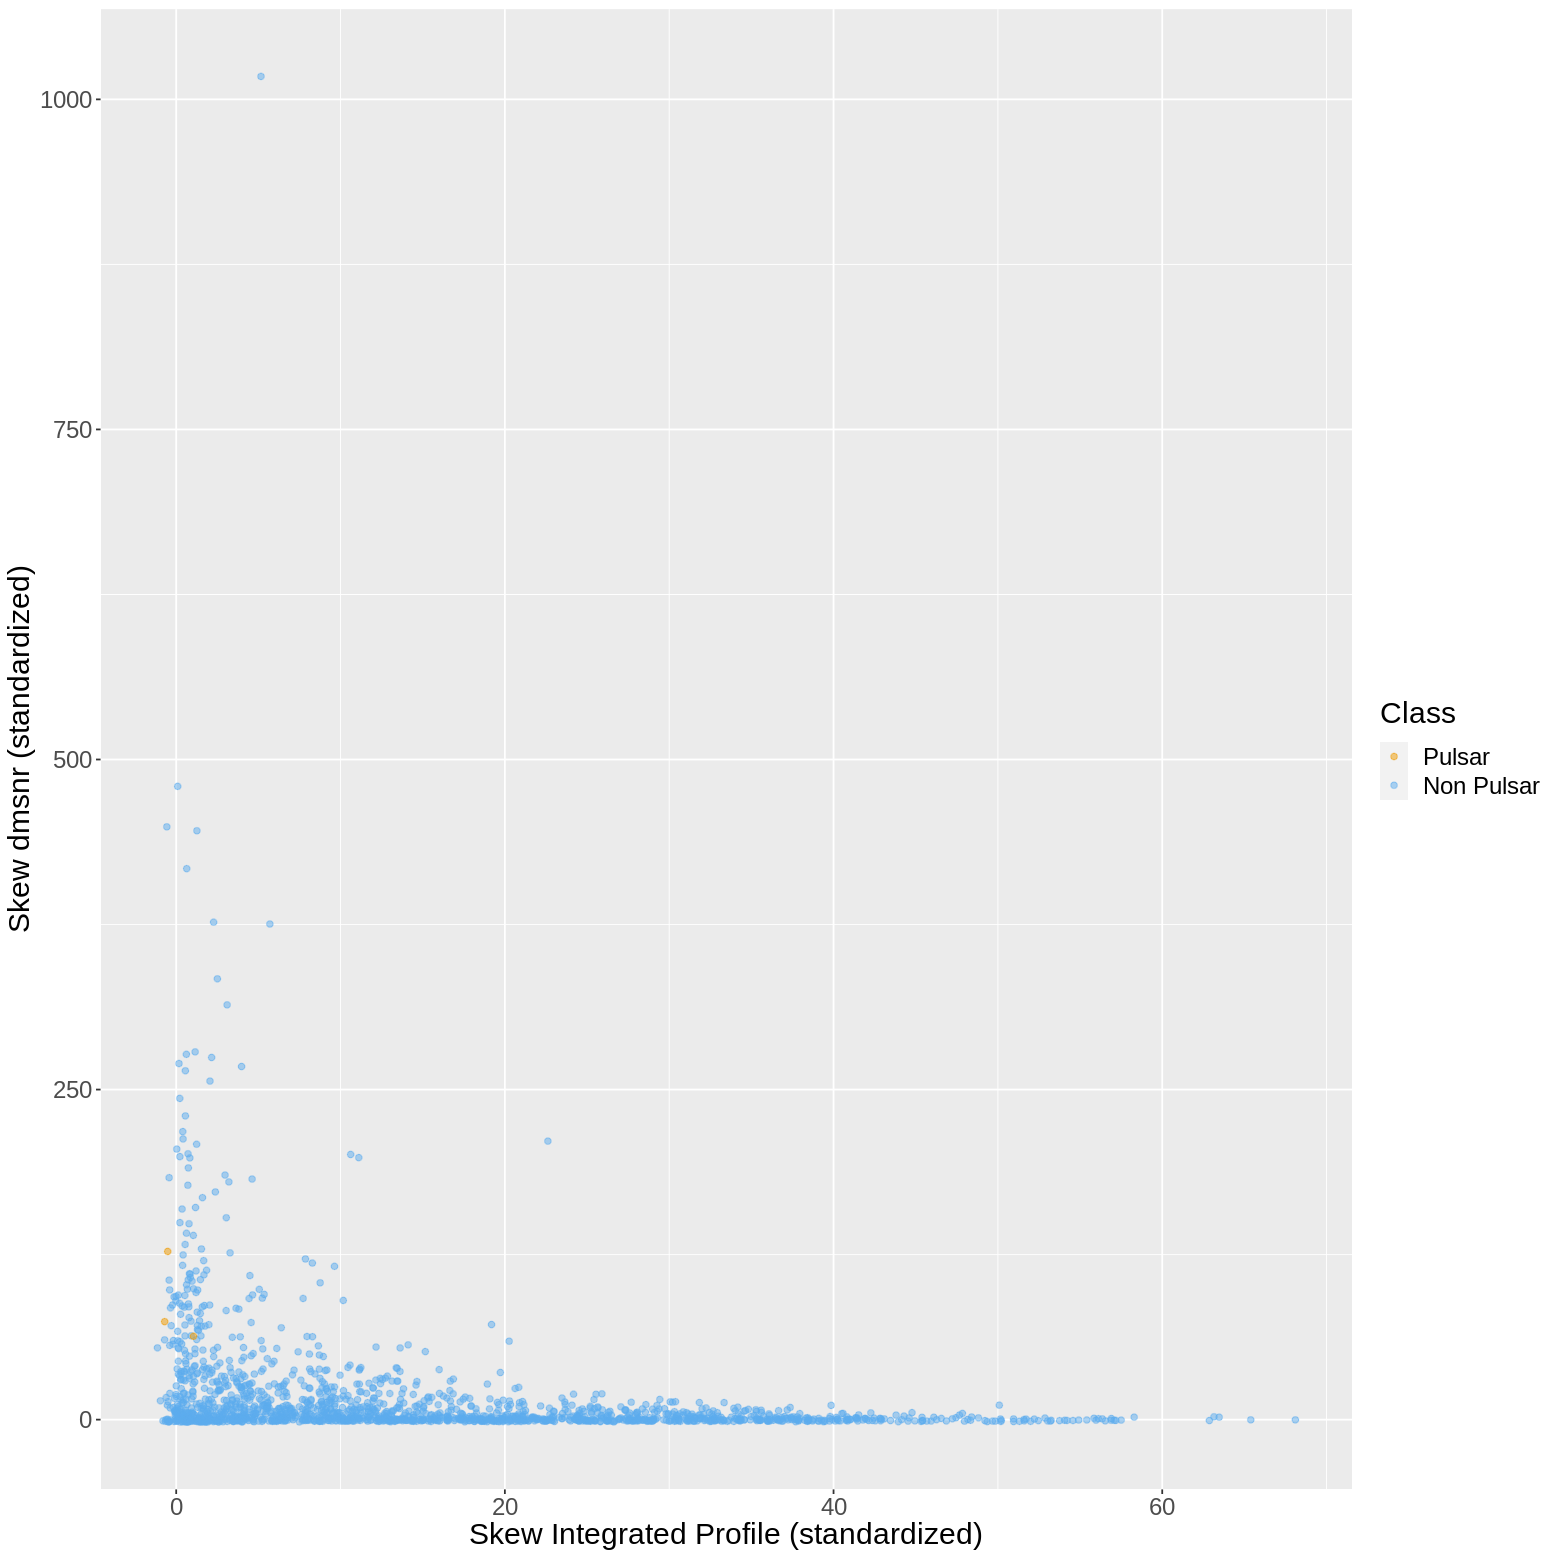

In [46]:
rare_pulsar <- bind_rows(
      filter(pulsar_data, class == "P"),
      pulsar_data |> filter(class == "NP") |> slice_head(n = 3)
    ) |>
    select(class, skew_integrated_profile, skew_dmsnr)

rare_plot <- rare_pulsar |>
  ggplot(aes(x = skew_integrated_profile, y = skew_dmsnr, color = class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Skew Integrated Profile (standardized)", 
       y = "Skew dmsnr (standardized)",
       color = "Class") +
  scale_color_manual(labels = c("Pulsar", "Non Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18))

rare_plot

As we can see from the proportion and plot, we have to balance the train data set. Otherwise we will not learn correctly. Indeed, the algorithm will not have enough information about Pulsar Star.

For the present purposes, it will suffice to rebalance the data by oversampling the rare class. In other words, we will duplicate randomly observations of class 1 until we have the same number of class 0 and class 1 in our training set.

**Selecting Predictors**

To address our project question, we perform steps to determine an estimate of how accuracte our classififcation model would be, given various predictor combinations. We select the set of predictors that is expected to yield the most accuract classifier to use in our data analysis.

Here, we split our dataset into training and testing sets.

In [36]:
set.seed(1)
standardized_data <- pulsar_data |> 
    mutate(across(mean_integrated_profile:skew_dmsnr,scale)) #standardize the values
standardized_data
pulsar_split <- initial_split(standardized_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>
1.1492849,1.3347944,-0.66955083,-0.4004478,-0.3194313,-0.3706151,-0.07279575,-0.2874301,NP
-0.3341589,1.8022150,-0.01178443,-0.3705251,-0.3710915,-0.5889076,0.50441285,0.2115755,NP
-0.3143634,-1.0532928,-0.14522850,-0.1165896,-0.3220980,-0.2353216,-0.12599257,-0.3913625,NP
1.0006664,1.5532110,-0.51339427,-0.3901672,-0.3043957,-0.2756588,-0.31225666,-0.4812869,NP
-0.8713781,-0.8588548,0.11560548,-0.1048632,-0.3879995,-0.7630898,1.32398915,1.3867553,NP
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.9881801,1.9432298,-0.6256372,-0.4066857,-0.3839995,-0.7272746,1.586009,1.6999868,NP
0.4473063,0.4290505,-0.3288215,-0.2346366,0.1287725,0.9398993,-1.189126,-0.9065487,NP
0.3218333,1.9561650,-0.2993254,-0.4074805,0.2991291,1.6715218,-1.288043,-0.9413038,NP


In [37]:
names <- colnames(pulsar_train |> select(-class))
names

[1] "mean_integrated_profile"         "stand_dev_integrated_profile"   
[3] "exc_kurtosis_integrated_profile" "skew_integrated_profile"        
[5] "mean_dmsnr"                      "stand_dev_dmsnr"                
[7] "exc_kurtosis_dmsnr"              "skew_dmsnr"

In [38]:
example_formula <- paste("class", "~", paste(names, collapse="+"))
example_formula

[1] "class ~ mean_integrated_profile+stand_dev_integrated_profile+exc_kurtosis_integrated_profile+skew_integrated_profile+mean_dmsnr+stand_dev_dmsnr+exc_kurtosis_dmsnr+skew_dmsnr"

In [39]:
# create an empty tibble to store the results
predictor_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [42]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())                        #do we need to upsample the training set first??
        
        #set up a model
        knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
            set_engine("kknn") |>
            set_mode("classification")                                        #are we just choosing an arbitrary K value here???

        pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)
        
        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(pulsar_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = pulsar_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
predictor_accuracies <- predictor_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
predictor_accuracies

Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ exc_kurtosis_integrated_profile,0.9759367
2,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr,0.9764587
3,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile,0.9782464
4,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile+mean_dmsnr,0.9799599
5,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile,0.9794371
6,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr,0.9791402
7,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr+skew_dmsnr,0.9789909
8,class ~ exc_kurtosis_integrated_profile+stand_dev_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr+skew_dmsnr+mean_integrated_profile,0.9786182


Based on the data above, the highest accuracy is obtained by having exc_kurtosis_integrated_profile, stand_dev_dmsnr, stand_dev_integrated_profile, and mean_dmsnr as predictors.

<b>Data Analysis and Results </b>

Since we loaded all of our libraries at the beginning of this report, and we have already read in our data, we can start by inspecting the dataset. We see that the percentage of observations corresponding to real pulsars is around 9%. Then, to preprocess the data, we scale and center our 4 predictors so that the variables have a mean of 0 and standard deviation of 1.

In [ ]:
#Add columns
#unscaled_data <- read_csv("pulsar_data.csv", 
 #                       col_names = c("mean_integrated_profile", 
  #                                    "stand_dev_integrated_profile", 
   #                                   "exc_kurtosis_integrated_profile", 
    #                                  "skew_integrated_profile",
     #                                 "mean_dmsnr", 
      #                                "stand_dev_dmsnr", 
       #                               "exc_kurtosis_dmsnr", 
        #                              "skew_dmsnr", "class")) 

#unscaled_data <- unscaled_data |>
#    drop_na() |>
#    mutate(class = as_factor(class))
#unscaled_data 

#Class proportions in pulsar training set (Imbalanced)
num_obs <- nrow(pulsar_train)
pulsar_proportions <- pulsar_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_train))
pulsar_proportions

#Scale data
pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile + skew_dmsnr + stand_dev_integrated_profile + 
                        mean_dmsnr + skew_integrated_profile + exc_kurtosis_dmsnr, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

standardized_pulsar <- bake(pulsar_recipe, pulsar_train)
standardized_pulsar

Here, we split our preprocessed data into training and testing sets, and put 75% of the data into the training set. As mentioned earlier, to balance the proportion of real pulsar observations to false pulsar observations, we upsample the portion of the dataset that we want to use to train our model (i.e. create more real pulsar observations that have predictor values similar to those in the original set). We also build our recipe given our chosen predictors.

In [43]:
set.seed(1)
#pulsar_split <- initial_split(standardized_pulsar, prop = 0.75, strata = class)
#pulsar_train <- training(pulsar_split)
#pulsar_test <- testing(pulsar_split) 

#Check class proportions in the training set
pulsar_proportions <- pulsar_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_train))
pulsar_proportions

#Upscale data to balance training set
pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr,
                        data = pulsar_train) |>
    step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep |>
pulsar_recipe

pulsar_train <- bake(pulsar_recipe, pulsar_train)
pulsar_train

#Check new proportions in training set
new_pulsar_proportions <- pulsar_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_train))
new_pulsar_proportions

ERROR: Error in parse(text = x, srcfile = src): The pipe operator requires a function call as RHS


Now we perform cross validation on the training set in order to select the best K value for our classifier (number of neighbors). To do this, we use 10 folds. But first, we build a classification model that specifies that we want to tune the number of neighbors. We create a tibble that contains each K value that we want to test.

In [ ]:
#build the model, CAUTION: Takes a long time to load.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a tibble for the K values
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 3))
#k_vals

#Set up and perform 10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics() #assess the accuracy 
knn_results

To determine the best K to use, we filter the collected metrics from cross validation and plot the accuracy against the K values we tested.

In [ ]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy vs. K") +
       theme(text = element_text(size = 20))
accuracy_versus_k

Based on the above plot, we see that the accuracy decreases quite steeply as the number of neighbors increases, before leveling off from around K = 16 onwards. We choose K = 17 for our classification model because the accuracy is high at this point, and the accuracy does not change drastically when looking at similar K values. Overall, we want to avoid overfitting the data by selecting too few neighbors, and 17 is an odd number (given that K-nearest neighbors classifies observations based on a majority rules system, using an even number of neighbors could be problematic in the event of a tie, since our class variable is binary). 

Upon determining the optimal K value for our classifier, we can finally predict on our testing set. As done below, we use the same recipe as before, but a new model that sets the number of neighbors to 17 must be built. Once we have used the model to predict the classes of the observations in the test set, we take a confusion matrix to view the accuracy.

In [ ]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                    set_engine("kknn") |>
                    set_mode("classification")

pulsar_fit_final <- workflow() |>
        add_recipe(pulsar_recipe) |>
        add_model(knn_spec_final) |>
        fit(data = pulsar_train)

pulsar_test_predictions_final <-  predict(pulsar_fit_final, pulsar_test) |>
        bind_cols(pulsar_test)

pulsar_test_predictions_final                

confusion_final <- pulsar_test_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
confusion_final

To visualize the accuracy of our classification model, we create a new column in the predictions table that will allow us to visualze the test data in such a way that colour-coding the observations will let us see the information stored in the confusion matrix. (***not worded very well)

In [ ]:
mutated_predictions <- pulsar_test_predictions_final |>
    mutate(new_cat = case_when(.pred_class == 0 & class == 0 ~ "False pulsar, correctly classified",
                               .pred_class == 1 & class == 1 ~ "Real pulsar, correctly classified",
                               .pred_class == 1 & class == 0 ~ "False pulsar, incorrectly classified",
                               .pred_class == 0 & class == 1 ~ "Real pulsar, incorrectly classified"))
mutated_predictions

#this code came from: https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825 

<b> Visualization: Classifier accuracy </b>

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 14)

#First 2 predictors
plot_1 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = exc_kurtosis_integrated_profile, 
                                                              y = mean_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Excess Kurtosis - Integrated Profile", y = "Scaled Mean - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to mean of DMSNR
                \ncurve and excess kurtosis of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_1



#Next 2 predictors
plot_2 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = skew_dmsnr,
                                                              y = skew_integrated_profile, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Skewness - DMSNR curve", y = "Scaled Skewness - Integrated Profile", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to skewkness
                \nof both DMSNR curve and integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_2



#Last 2 predictors
plot_3 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = stand_dev_integrated_profile, 
                                                             y = exc_kurtosis_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Standard Deviation - Integrated Profile", y = "Scaled Excess Kurtosis - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to excess kurtosis of
                \nDMSNR curve and standard deviation of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_3

As can be seen above, there are very few observations in the testing set that were incorrectly classified. This indicates that our model is quite accurate. We can represent the accuracy of our model as a percentage, as well:

In [ ]:
#From the confusion matrix:

accuracy_perc <- ((3838 + 3853)/8130)*100
accuracy_perc

Therefore, <b> ~__% </b> is a good estimate of how accuracte our classification model is.

<b>Discussion </b>

summarize what you found: We found that training a classifier with our predictors (name them*) yields the most accurate predictions on new observations (i.e. the testing set). The accuracy of our model is __.

discuss whether this is what you expected to find?
- Personally, before upsampling I wasn’t expecting a really high prediction accuracy with any combination of predictors, due to how rare the real pulsars were in the original dataset
- Also, I don’t think I was expecting that the most accurate classifier would come from using 6 of the 8 variables available to us in the dataset → in our class readings it was mentioned that using very few or many predictors often harms how good the classifier is at making predictions (would have expected between 2-4 predictors to give the highest accuracy)

discuss what impact could such findings have?

discuss what future questions could this lead to?

**References**

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Keith, M. J., et al. (2010). The HTRU survey. Handbook of pulsar astronomy, 379-422.

United States. National Aeronautics and Space Administration. NASA technical note. Washington :National Aeronautics and Space Administration.

Paula, G. (2020, February 5). Creating a new variable under conditions of other two variables. Posit Community. Retrieved April 13, 2023, from https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825  

do we need to cite the textbook?